<a href="https://colab.research.google.com/github/CYBORGBC/Secret-Image-Sharing/blob/main/Image_sharing_using_GAN_(Visual_Cryptography).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Using image: /content/istockphoto-1471401435-612x612.jpg
Creating 4 completely secure shares using GAN architecture


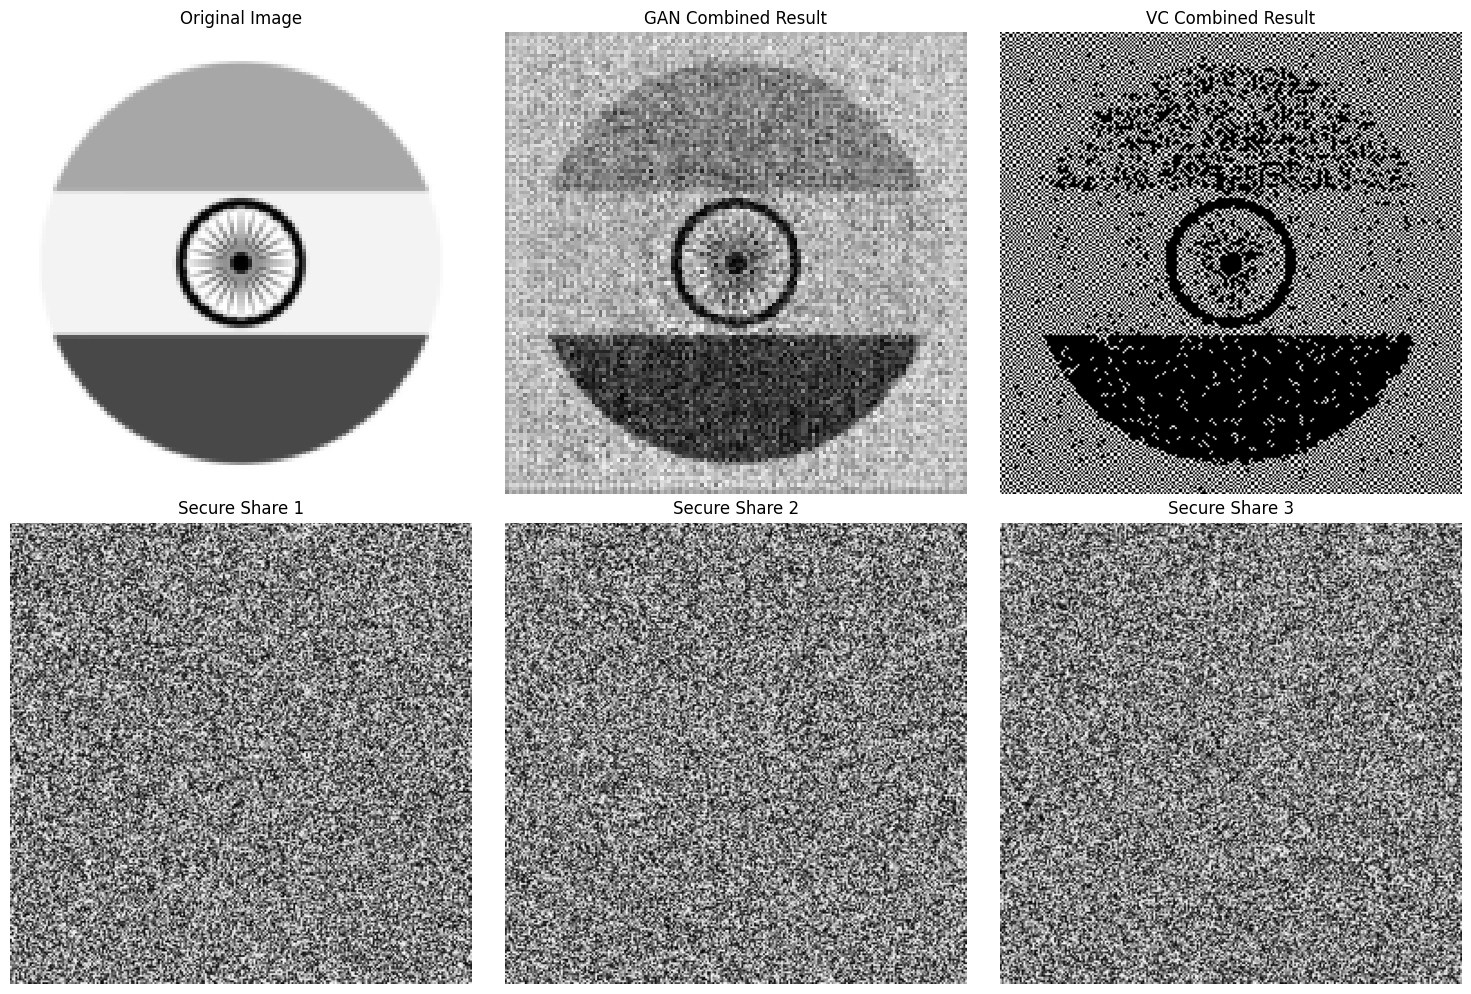


Secure GAN Visual Cryptography Completed!
Created 4 completely secure shares
Files saved in 'results' directory:
- secure_share_1.png
- secure_share_2.png
- secure_share_3.png
- secure_share_4.png
- gan_combined.png - Higher quality combination
- vc_combined.png - True visual crypto combination
- final_secure_shares.png (comparison figure)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
from torchvision.utils import save_image

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for loading images
class ImageDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image = Image.open(image_path).convert('L')  # Convert to grayscale
        self.transform = transform

    def __len__(self):
        return 1  # We're just using a single image

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.image)
        else:
            image = transforms.ToTensor()(self.image)
        return image

# Generator Network (Creates multiple shares)
class ShareGenerator(nn.Module):
    def __init__(self, img_size=128, num_shares=4, latent_dim=100):
        super(ShareGenerator, self).__init__()
        self.img_size = img_size
        self.num_shares = num_shares
        self.latent_dim = latent_dim

        # Encoder part (compress the image)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Create decoders for each share (with added random noise input)
        self.share_decoders = nn.ModuleList()
        for _ in range(num_shares):
            # Each decoder gets the encoded image features plus random noise
            decoder = nn.Sequential(
                nn.ConvTranspose2d(256 + latent_dim, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
                nn.BatchNorm2d(32),
                nn.ReLU(True),
                nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
                nn.Sigmoid()
            )
            self.share_decoders.append(decoder)

    def forward(self, x):
        batch_size = x.size(0)
        # Encode the image
        encoded_img = self.encoder(x)

        # Generate all shares with different random noise for each
        shares = []
        for decoder in self.share_decoders:
            # Create random noise and reshape to match encoded image dimensions
            noise = torch.randn(batch_size, self.latent_dim, 1, 1, device=x.device)
            noise = noise.expand(batch_size, self.latent_dim, 8, 8)  # Match spatial dimension of encoded image

            # Concatenate encoded image with noise along channel dimension
            input_features = torch.cat([encoded_img, noise], dim=1)

            # Generate share
            share = decoder(input_features)
            shares.append(share)

        return shares

# Discriminator for individual shares (to ensure they look visually different from original)
class ShareDiscriminator(nn.Module):
    def __init__(self, img_size=128):
        super(ShareDiscriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: 1 x 128 x 128
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=8, stride=1, padding=0),  # 8x8 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator for combined result (ensures reconstruction looks like original)
class CombinedDiscriminator(nn.Module):
    def __init__(self, img_size=128):
        super(CombinedDiscriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: 1 x 128 x 128
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=8, stride=1, padding=0),  # 8x8 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ====== IMPROVED VISUAL CRYPTOGRAPHY FUNCTIONS ========

# Function to convert shares to binary visual cryptography format
def convert_to_binary_share(share, threshold=0.5):
    """Convert continuous shares to binary format for true visual cryptography"""
    # Apply threshold to convert to binary
    binary = (share > threshold).float()
    return binary

# Function to apply visual cryptography encoding
def apply_vc_encoding(shares, img_size=128):
    """Apply classic visual cryptography encoding to make shares visually secure"""
    n_shares = len(shares)
    batch_size = shares[0].size(0)

    # Up-sample to 2x size for VC encoding (each pixel becomes 2x2 block)
    expanded_height = img_size * 2
    expanded_width = img_size * 2

    # Create binary shares with expanded dimensions
    vc_shares = []
    for i in range(n_shares):
        vc_share = torch.zeros((batch_size, 1, expanded_height, expanded_width), device=shares[0].device)
        vc_shares.append(vc_share)

    # Process each pixel according to visual cryptography
    for y in range(img_size):
        for x in range(img_size):
            # For each original pixel
            pixel_values = [share[0, 0, y, x].item() for share in shares]
            sum_val = sum(pixel_values)

            # 1. Determine if this pixel contributes to final image (using average as threshold)
            is_dark = sum_val < 0.5 * n_shares

            if is_dark:
                # For dark pixels in final image, use complementary patterns
                # The sum of subpixels is always different by n_shares
                for i in range(n_shares):
                    # Generate a random pattern for the first share
                    if i == 0:
                        r = random.random()
                        if r > 0.5:
                            # Pattern type 1: [BW/WB]
                            vc_shares[i][0, 0, y*2, x*2] = 0      # Black
                            vc_shares[i][0, 0, y*2, x*2+1] = 1    # White
                            vc_shares[i][0, 0, y*2+1, x*2] = 1    # White
                            vc_shares[i][0, 0, y*2+1, x*2+1] = 0  # Black
                        else:
                            # Pattern type 2: [WB/BW]
                            vc_shares[i][0, 0, y*2, x*2] = 1      # White
                            vc_shares[i][0, 0, y*2, x*2+1] = 0    # Black
                            vc_shares[i][0, 0, y*2+1, x*2] = 0    # Black
                            vc_shares[i][0, 0, y*2+1, x*2+1] = 1  # White
                    else:
                        # For all other shares, use complementary pattern to first share
                        vc_shares[i][0, 0, y*2, x*2] = 1 - vc_shares[0][0, 0, y*2, x*2]
                        vc_shares[i][0, 0, y*2, x*2+1] = 1 - vc_shares[0][0, 0, y*2, x*2+1]
                        vc_shares[i][0, 0, y*2+1, x*2] = 1 - vc_shares[0][0, 0, y*2+1, x*2]
                        vc_shares[i][0, 0, y*2+1, x*2+1] = 1 - vc_shares[0][0, 0, y*2+1, x*2+1]
            else:
                # For light pixels in final image, use same pattern in all shares
                r = random.random()
                for i in range(n_shares):
                    if r > 0.5:
                        # Pattern type 1: [BW/WB]
                        vc_shares[i][0, 0, y*2, x*2] = 0      # Black
                        vc_shares[i][0, 0, y*2, x*2+1] = 1    # White
                        vc_shares[i][0, 0, y*2+1, x*2] = 1    # White
                        vc_shares[i][0, 0, y*2+1, x*2+1] = 0  # Black
                    else:
                        # Pattern type 2: [WB/BW]
                        vc_shares[i][0, 0, y*2, x*2] = 1      # White
                        vc_shares[i][0, 0, y*2, x*2+1] = 0    # Black
                        vc_shares[i][0, 0, y*2+1, x*2] = 0    # Black
                        vc_shares[i][0, 0, y*2+1, x*2+1] = 1  # White

    return vc_shares

# Function to make shares completely secure by randomizing them
def secure_share(share):
    """Apply additional randomization to ensure share reveals nothing about the original"""
    # Create a completely random pattern
    random_pattern = torch.rand_like(share)

    # Apply pixel-wise XOR-like operation
    # In the context of images with values in [0,1], we can approximate XOR:
    # a XOR b ≈ a + b - 2ab
    secured_share = share + random_pattern - 2 * share * random_pattern

    # Apply random permutation of pixels
    batch_size, channels, height, width = share.shape
    flat_indices = torch.randperm(height * width)

    # Reshape for permutation
    flat_share = secured_share.view(batch_size, channels, -1)
    permuted_share = flat_share.clone()

    # Apply permutation
    for b in range(batch_size):
        for c in range(channels):
            permuted_share[b, c] = flat_share[b, c, flat_indices]

    # Reshape back
    permuted_share = permuted_share.view(batch_size, channels, height, width)

    return permuted_share

# Function to combine multiple shares for decryption
def combine_vc_shares(shares):
    """Combine visual cryptography shares to reveal the hidden image"""
    # For binary visual crypto, we use min operation (logical AND)
    result = torch.ones_like(shares[0])

    for share in shares:
        # Black pixels (0) in any share produce black pixels in result
        result = result * share

    return result

# Function to combine multiple shares (averaging method for GAN-generated shares)
def combine_multi_shares(shares):
    """Combine multiple shares by averaging (for continuous values)"""
    # Add all shares and normalize
    combined = sum(shares) / len(shares)
    return combined

def train_visual_crypto_gan(image_path="C:/Users/KIIT/OneDrive/Documents/Python jupyter notebook/original image.jpg",
                          num_shares=4, epochs=100, latent_dim=100):
    """
    Train a GAN-based visual cryptography system with multiple encrypted shares

    Args:
        image_path: Path to the input image
        num_shares: Number of shares to create (default: 4)
        epochs: Number of epochs to train for
        latent_dim: Dimension of latent noise vector
    """
    # Create results directory
    os.makedirs("results", exist_ok=True)

    # Parameters
    image_size = 128
    batch_size = 1

    # Transformations
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    print(f"Using image: {image_path}")
    print(f"Creating {num_shares} completely secure shares using GAN architecture")

    # Create dataset and dataloader
    dataset = ImageDataset(image_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize models
    generator = ShareGenerator(img_size=image_size, num_shares=num_shares, latent_dim=latent_dim).to(device)
    share_discriminator = ShareDiscriminator(img_size=image_size).to(device)
    combined_discriminator = CombinedDiscriminator(img_size=image_size).to(device)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D_share = optim.Adam(share_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D_combined = optim.Adam(combined_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Loss functions
    adversarial_loss = nn.BCELoss()
    reconstruction_loss = nn.MSELoss()

    # Labels for adversarial training
    real_label = 1.0
    fake_label = 0.0

    # Create reference noise patterns for each share
    reference_patterns = []
    for i in range(num_shares):
        torch.manual_seed(i * 1000 + 42)  # Different seed for each pattern
        pattern = torch.rand(1, 1, image_size, image_size).to(device)
        reference_patterns.append(pattern)

    # Training loop
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            imgs = imgs.to(device)
            batch_size = imgs.size(0)

            # Configure input
            real = imgs

            # Ground truths
            valid = torch.full((batch_size, 1, 1, 1), real_label, device=device)
            fake = torch.full((batch_size, 1, 1, 1), fake_label, device=device)

            # -----------------
            #  Train Discriminators
            # -----------------

            optimizer_D_share.zero_grad()
            optimizer_D_combined.zero_grad()

            # Generate shares
            gen_shares = generator(real)

            # Create combined image from shares
            combined_img = combine_multi_shares(gen_shares)

            # ------- Train Share Discriminator -------

            # Train with patterns (should be classified as real)
            # We want individual shares to look like intentional patterns
            pattern_validity = share_discriminator(reference_patterns[0])
            share_d_real_loss = adversarial_loss(pattern_validity, valid)

            # Train with generated shares (should be classified as fake if too similar to original)
            share_d_fake_loss = 0
            for share in gen_shares:
                fake_validity = share_discriminator(share.detach())
                share_d_fake_loss += adversarial_loss(fake_validity, fake)
            share_d_fake_loss /= len(gen_shares)

            share_d_loss = (share_d_real_loss + share_d_fake_loss) / 2
            share_d_loss.backward()
            optimizer_D_share.step()

            # ------- Train Combined Discriminator -------

            # Train with real images
            real_validity = combined_discriminator(real)
            combined_d_real_loss = adversarial_loss(real_validity, valid)

            # Train with combined images (should be classified based on reconstruction quality)
            fake_validity = combined_discriminator(combined_img.detach())
            combined_d_fake_loss = adversarial_loss(fake_validity, fake)

            combined_d_loss = (combined_d_real_loss + combined_d_fake_loss) / 2
            combined_d_loss.backward()
            optimizer_D_combined.step()

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate shares again (for fresh gradients)
            gen_shares = generator(real)
            combined_img = combine_multi_shares(gen_shares)

            # Adversarial loss for share discriminator
            # We want shares to look like intentional patterns (classified as real)
            share_validity_loss = 0
            for share in gen_shares:
                validity = share_discriminator(share)
                share_validity_loss += adversarial_loss(validity, valid)
            share_validity_loss /= len(gen_shares)

            # Adversarial loss for combined discriminator
            # We want combined image to look like original (classified as real)
            combined_validity = combined_discriminator(combined_img)
            combined_validity_loss = adversarial_loss(combined_validity, valid)

            # Reconstruction loss (combined should match original)
            rec_loss = reconstruction_loss(combined_img, real)

            # Diversity loss (each share should be different)
            diversity_loss = 0
            for i in range(len(gen_shares)):
                for j in range(i+1, len(gen_shares)):
                    similarity = 1.0 - torch.mean((gen_shares[i] - gen_shares[j])**2)
                    diversity_loss += similarity
            diversity_loss /= (len(gen_shares) * (len(gen_shares) - 1) / 2)

            # Total generator loss
            g_loss = (
                share_validity_loss * 1.0 +          # Shares should look like patterns
                combined_validity_loss * 1.0 +       # Combined should look like original
                rec_loss * 50.0 +                    # Reconstruction loss (most important)
                diversity_loss * 5.0                 # Diversity between shares
            )

            g_loss.backward()
            optimizer_G.step()

            # Print progress
            if i % 10 == 0:
                print(
                    f"[Epoch {epoch}/{epochs}] "
                    f"[D_share loss: {share_d_loss.item():.4f}] "
                    f"[D_comb loss: {combined_d_loss.item():.4f}] "
                    f"[G loss: {g_loss.item():.4f}] "
                    f"[Rec loss: {rec_loss.item():.4f}]"
                )

        # Save sample images every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            with torch.no_grad():
                for img in dataloader:
                    img = img.to(device)
                    gen_shares = generator(img)

                    # Convert shares to true visual cryptography format
                    binary_shares = [convert_to_binary_share(share) for share in gen_shares]
                    vc_shares = apply_vc_encoding(binary_shares, img_size=image_size)

                    # Apply full security measures to make shares unidentifiable
                    secured_shares = [secure_share(share) for share in vc_shares]

                    # Create combined image for display (from original shares)
                    combined_img = combine_multi_shares(gen_shares)

                    # Convert to numpy for display
                    orig_img = img[0].cpu().numpy().squeeze()
                    secured_share_imgs = [share[0].cpu().numpy().squeeze() for share in secured_shares]
                    combined_img = combined_img[0].cpu().numpy().squeeze()

                    # Save progress image
                    plt.figure(figsize=(15, 10))

                    # Display original
                    num_cols = min(4, num_shares + 2)
                    num_rows = ((num_shares + 2) + num_cols - 1) // num_cols

                    plt.subplot(num_rows, num_cols, 1)
                    plt.title("Original Image")
                    plt.imshow(orig_img, cmap='gray')
                    plt.axis('off')

                    # Display each encrypted share
                    for i, share_img in enumerate(secured_share_imgs):
                        plt.subplot(num_rows, num_cols, i+2)
                        plt.title(f"Secure Share {i+1}")
                        plt.imshow(share_img, cmap='gray')
                        plt.axis('off')

                    # Display combined result
                    plt.subplot(num_rows, num_cols, num_shares+2)
                    plt.title("Combined Result")
                    plt.imshow(combined_img, cmap='gray')
                    plt.axis('off')

                    plt.tight_layout()
                    plt.savefig(f"results/secure_shares_epoch_{epoch+1}.png", dpi=200)
                    plt.close()
                    break

    # Save the final model
    torch.save({
        'generator': generator.state_dict(),
        'share_discriminator': share_discriminator.state_dict(),
        'combined_discriminator': combined_discriminator.state_dict()
    }, f"secure_gan_crypto_model_{num_shares}shares.pth")

    # Generate final results
    generator.eval()
    with torch.no_grad():
        for img in dataloader:
            img = img.to(device)
            gen_shares = generator(img)

            # Convert to true visual cryptography for complete security
            binary_shares = [convert_to_binary_share(share) for share in gen_shares]
            vc_shares = apply_vc_encoding(binary_shares, img_size=image_size)

            # Apply additional security measures
            secured_shares = [secure_share(share) for share in vc_shares]

            # Combined image (original GAN shares for quality)
            combined_img = combine_multi_shares(gen_shares)

            # Also create a combined version of the VC shares for comparison
            vc_combined = combine_vc_shares(vc_shares)

            # Convert to numpy for display
            orig_img = img[0].cpu().numpy().squeeze()
            secured_share_imgs = [share[0].cpu().numpy().squeeze() for share in secured_shares]
            combined_img = combined_img[0].cpu().numpy().squeeze()
            vc_combined_img = vc_combined[0].cpu().numpy().squeeze()

            # Save individual images
            for i, share_img in enumerate(secured_share_imgs):
                plt.imsave(f"results/secure_share_{i+1}.png", share_img, cmap='gray')
            plt.imsave("results/gan_combined.png", combined_img, cmap='gray')
            plt.imsave("results/vc_combined.png", vc_combined_img, cmap='gray')
            plt.imsave("results/original.png", orig_img, cmap='gray')

            # Create figure for final display
            plt.figure(figsize=(15, 10))

            # Display original and results
            plt.subplot(2, 3, 1)
            plt.title("Original Image")
            plt.imshow(orig_img, cmap='gray')
            plt.axis('off')

            # Display combined result (GAN)
            plt.subplot(2, 3, 2)
            plt.title("GAN Combined Result")
            plt.imshow(combined_img, cmap='gray')
            plt.axis('off')

            # Display combined result (VC)
            plt.subplot(2, 3, 3)
            plt.title("VC Combined Result")
            plt.imshow(vc_combined_img, cmap='gray')
            plt.axis('off')

            # Display each secured share
            for i, share_img in enumerate(secured_share_imgs[:3]):  # Show up to 3 shares
                plt.subplot(2, 3, i+4)
                plt.title(f"Secure Share {i+1}")
                plt.imshow(share_img, cmap='gray')
                plt.axis('off')

            plt.tight_layout()
            plt.savefig("results/final_secure_shares.png", dpi=300)
            plt.show()
            break

    print("\nSecure GAN Visual Cryptography Completed!")
    print(f"Created {num_shares} completely secure shares")
    print("Files saved in 'results' directory:")
    for i in range(num_shares):
        print(f"- secure_share_{i+1}.png")
    print("- gan_combined.png - Higher quality combination")
    print("- vc_combined.png - True visual crypto combination")
    print("- final_secure_shares.png (comparison figure)")

if __name__ == "__main__":
    # Run the GAN-based visual cryptography system with fully secured shares
    train_visual_crypto_gan(
        image_path="/content/istockphoto-1471401435-612x612.jpg",
        num_shares=4,  # Create 4 shares
        epochs=100,    # Train for 100 epochs
        latent_dim=100 # Random noise dimension
    )